In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
ts = pd.read_csv('datasets/time_series/renewables_series.csv')
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
ts.head(2)

,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12 00:00:00,0.0,4228.0,706.0,242.0,242.0
2018-04-12 00:05:00,0.0,4196.0,716.0,238.0,242.0


### Calculate mean megawatt demand each hour
- This allows for forecasting data in megawatt hours in future methods

In [3]:
mwh = ts.resample('H').mean()
print(mwh.shape)
mwh.head(2)

(18504, 5)


,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12 00:00:00,0.0,4334.916667,688.25,243.166667,241.333333
2018-04-12 01:00:00,0.0,4197.000000,654.75,236.916667,241.083333


### Read in weather data

In [5]:
wind = pd.read_csv('datasets/time_series/wind_cluster.csv')
wind['date'] = pd.to_datetime(wind['date'],format='%Y-%m-%dT%H:%M:%S')
wind.set_index('date',inplace=True)
wind.index = pd.to_datetime(wind.index)
print(wind.shape)

(768, 7)


In [6]:
wind['total_wind'] = wind.sum(axis=1)

In [8]:
test = pd.merge(wind,mwh['wind'],how='left',left_index=True, right_index=True)
print(test.shape)
test.head(2)

(768, 9)


,0,1,2,3,4,5,6,total_wind,wind
date,,,,,,,,,
2020-03-15 00:00:00,28209.12,11603.62,7566.35,4256.0,2087.4,506.0,6264.16,60492.65,1728.250000
2020-03-15 01:00:00,28209.12,11603.62,9629.90,4256.0,2087.4,303.6,6711.60,62801.24,1464.333333


In [12]:
wind_test = test[['total_wind','wind']]

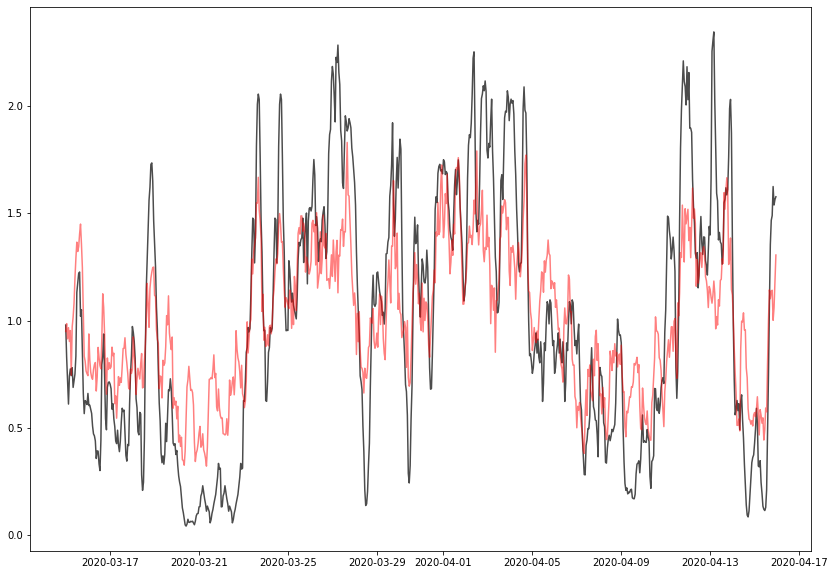

In [13]:
plt.figure(figsize=(14,10))
plt.plot(wind_test.index,wind_test['wind']/np.mean(uv_test['wind']),'k-',alpha=0.7)
plt.plot(wind_test.index,wind_test['total_wind']/np.mean(uv_test['total_wind']),'r-',alpha=0.5)

In [14]:
wind_daily = wind_test.resample('D').sum()

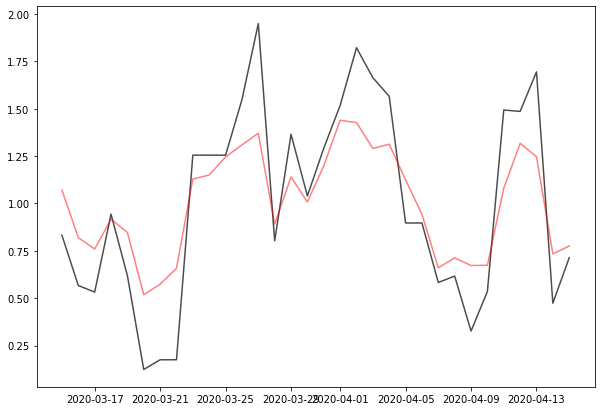

In [16]:
plt.figure(figsize=(10,7))
plt.plot(wind_daily.index,wind_daily['wind']/np.mean(wind_daily['wind']),'k-',alpha=0.7)
plt.plot(wind_daily.index,wind_daily['total_wind']/np.mean(wind_daily['total_wind']),'r-',alpha=0.5)

### Linear Regression 1
- just total_uv


In [17]:
wind_test.corr()

,total_wind,wind
total_wind,1.000000,0.848435
wind,0.848435,1.000000


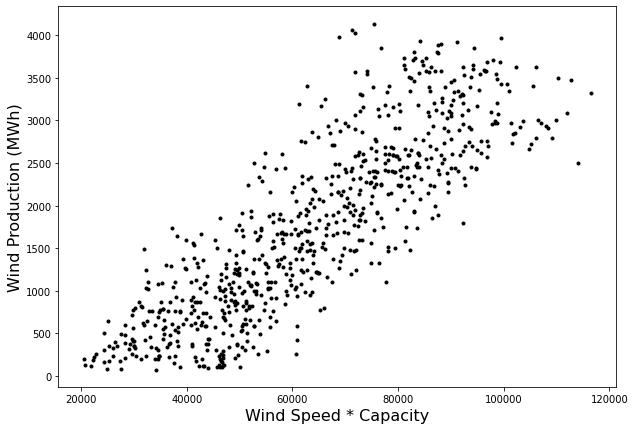

In [18]:
plt.figure(figsize=(10,7))
plt.plot(wind_test[wind_test['total_wind']>0]['total_wind'],wind_test[wind_test['total_wind']>0]['wind'],'k.',label='true')
plt.xlabel('Wind Speed * Capacity',fontsize=16)
plt.ylabel('Wind Production (MWh)',fontsize=16);

In [26]:
X = wind_test['total_wind'].astype('float64').values.reshape(-1,1)
y = wind_test['wind'].astype('float64').values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,shuffle=False)

In [27]:
lr = LinearRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

RMSE = 696.8742759049857


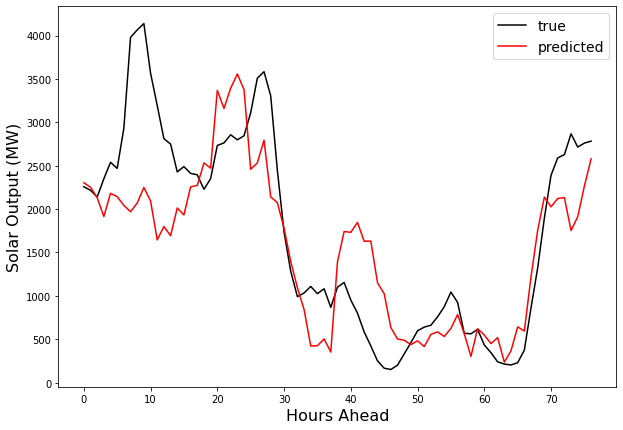

In [31]:
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, preds))}")
plt.figure(figsize=(10,7))
plt.plot(y_test,'k-',label='true')
plt.plot(preds,'r-',label='predicted')
plt.legend(fontsize=14)
plt.xlabel('Hours Ahead',fontsize=16)
plt.ylabel('Solar Output (MW)',fontsize=16);

### Regression 2
- include windspeeds as independent channels

In [81]:
X = pd.read_csv('datasets/time_series/cluster_windspeed.csv')
X['date'] = pd.to_datetime(X['date'],format='%Y-%m-%dT%H:%M:%S')
X.set_index('date',inplace=True)
X.index = pd.to_datetime(X.index)
print(X.shape)
X.head(2)

(768, 7)


,0,1,2,3,4,5,6
date,,,,,,,
2020-03-15 00:00:00,8,7,11,14,7,5,14
2020-03-15 01:00:00,8,7,14,14,7,3,15


In [82]:
y = wind_test['wind']
print(y.shape)

(768,)


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.08,shuffle=False)

In [84]:
lr = LinearRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

RMSE = 549.591262062039


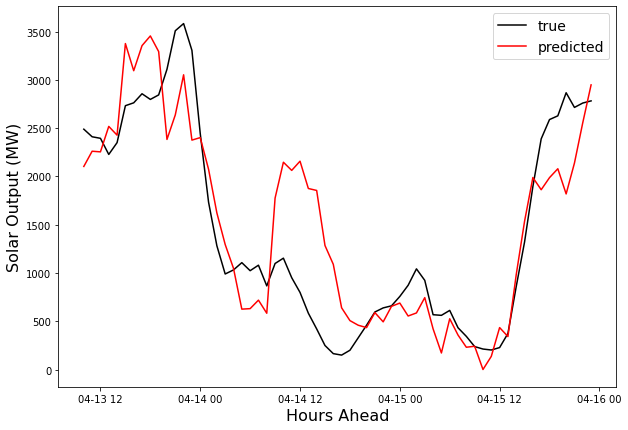

In [85]:
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, preds))}")
plt.figure(figsize=(10,7))
plt.plot(y_test.index,y_test,'k-',label='true')
plt.plot(y_test.index,preds,'r-',label='predicted')
plt.legend(fontsize=14)
plt.xlabel('Hours Ahead',fontsize=16)
plt.ylabel('Solar Output (MW)',fontsize=16);

### Linear Regression 3
- include humidity

In [86]:
hum = pd.read_csv('datasets/time_series/cluster_humidity.csv')
print(hum.shape)
hum.head()

(768, 8)


,date,0,1,2,3,4,5,6
0,2020-03-15 00:00:00,71,86,65,75,66,100,94
1,2020-03-15 01:00:00,71,86,68,77,72,100,97
2,2020-03-15 02:00:00,73,85,68,78,76,100,99
3,2020-03-15 03:00:00,90,87,63,79,79,100,100
4,2020-03-15 04:00:00,87,86,66,79,80,100,100


In [87]:
# merge with X
X = pd.read_csv('datasets/time_series/cluster_windspeed.csv')
X['date'] = pd.to_datetime(X['date'],format='%Y-%m-%dT%H:%M:%S')
X.set_index('date',inplace=True)
X.index = pd.to_datetime(X.index)
X['h0'] = X['0'] + ((100-hum['0'].values)/100)*X['0'].values
X['h1'] = X['1'] + ((100-hum['1'].values)/100)*X['1'].values
X['h2'] = X['2'] + ((100-hum['2'].values)/100)*X['2'].values
X['h3'] = X['3'] + ((100-hum['3'].values)/100)*X['3'].values
X['h4'] = X['4'] + ((100-hum['4'].values)/100)*X['4'].values
X['h5'] = X['5'] + ((100-hum['5'].values)/100)*X['5'].values
X['h6'] = X['6'] + ((100-hum['6'].values)/100)*X['6'].values

print(X.shape)
X.head(2)

(768, 14)


,0,1,2,3,4,5,6,h0,h1,h2,h3,h4,h5,h6
date,,,,,,,,,,,,,,
2020-03-15 00:00:00,8,7,11,14,7,5,14,10.32,7.98,14.85,17.50,9.38,5.0,14.84
2020-03-15 01:00:00,8,7,14,14,7,3,15,10.32,7.98,18.48,17.22,8.96,3.0,15.45


In [88]:
y = wind_test['wind']
print(y.shape)

(768,)


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.08,shuffle=False)

In [90]:
lr = LinearRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

RMSE = 532.9556563762178


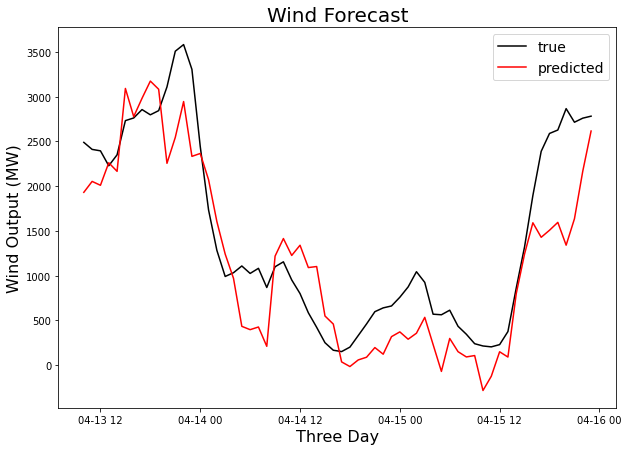

In [92]:
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, preds))}")
plt.figure(figsize=(10,7))
plt.plot(y_test.index,y_test,'k-',label='true')
plt.plot(y_test.index,preds,'r-',label='predicted')
plt.legend(fontsize=14)
plt.xlabel('Three Day',fontsize=16)
plt.ylabel('Wind Output (MW)',fontsize=16)
plt.title('Wind Forecast',fontsize=20);
#plt.savefig('./images/uv_linear_model.png',dpi=235,bbox_inches='tight');

### RNN model
- engineer new columns: hour of day, month, 